# Лабораторна робота №7
## ФБ-21 Тютюннікова Віолета
### Сценарії обробки багатоспектральних супутникових зображень
### *Мета: ознайомитися з основними принципами обробки даних дистанційного зондування Землі (ДЗ3) та можливостями мови Python для обробки геопросторової інформації, а саме, багатоспектральних супутникових зображень засобами бібліотеки абстракції супутникової інформації (GDAL).*
---

In [119]:
import os
import zipfile
import shutil
import subprocess
import rasterio
from rasterio.plot import show
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("Успішно становлено!")

Успішно становлено!


#### 1. Розпакування наборів архівів з продуктами Д33 в новостворені папки, назви яких відповідатимуть ідентифікаторам зображень.

In [120]:
archives = [ "lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip",
            "lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip" ]

def extract(archives):
    for archive_path in archives:
        extract_dir = os.path.splitext(archive_path)[0]
        
        if os.path.exists(extract_dir):
            shutil.rmtree(extract_dir)
            print(f"Видаляємо існуючий каталог {extract_dir}.")
        
        os.makedirs(extract_dir, exist_ok=True)
        print(f"Створюємо каталог {extract_dir}.")
        
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
            print(f"Розархівовуємо {archive_path} в {extract_dir}.")

extract(archives)
print("Архіви розпаковано.")

Створюємо каталог lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.
Розархівовуємо lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip в lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.
Створюємо каталог lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.
Розархівовуємо lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip в lab7_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.
Архіви розпаковано.


#### 2. Конкатенація каналів видимого, ближнього тa середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


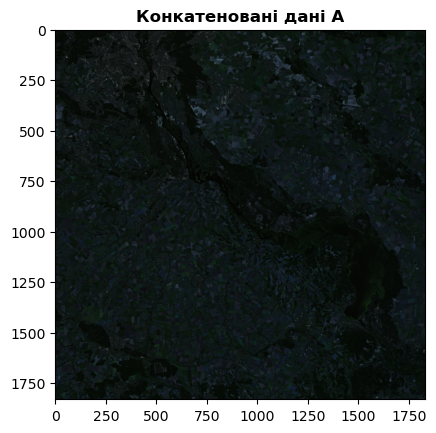

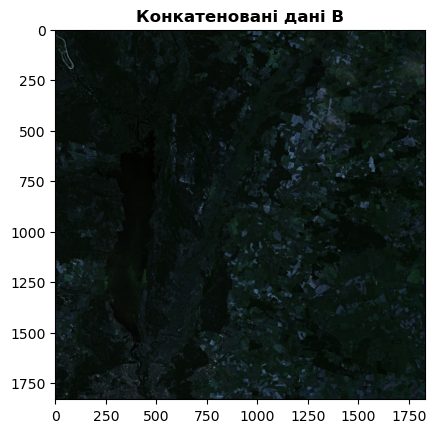

In [121]:
path = "lab7_data"

datasets = { 'A': "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206",
            'B': "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206" }

bands = ['B02', 'B03', 'B04', 'B8A']

data_paths = {}
for dataset, folder in datasets.items():
    data_paths[dataset] = {band: f"{path}/{folder}/{folder}.SAFE/GRANULE/L2A_T36UU{dataset}_A021740_20190821T085815/IMG_DATA/R60m/T36UU{dataset}_20190821T085601_{band}_60m.jp2" for band in bands}

output_dirs = [f"{path}/sentinel_concat/A", f"{path}/sentinel_concat/B"]

for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

for dataset, paths in data_paths.items():
    output = f'{path}/sentinel_concat/{dataset}/concat_{dataset}.tif'
    merge_cmd = f'gdal_merge.py -o {output} -separate {" ".join(paths.values())}'
    result = subprocess.run(merge_cmd, shell=True)

merged_datasets = {}
for dataset in ['A', 'B']:
    output = f'{path}/sentinel_concat/{dataset}/concat_{dataset}.tif'
    merged_datasets[dataset] = rasterio.open(output)

for dataset, raster in merged_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Конкатеновані дані {dataset}')


#### 3. Перепроектування супутникового зображення у проєкцію 4326.

Creating output file that is 2209P x 1423L.
Processing lab7_data/sentinel_concat/A/concat_A.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2222P x 1404L.
Processing lab7_data/sentinel_concat/B/concat_B.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


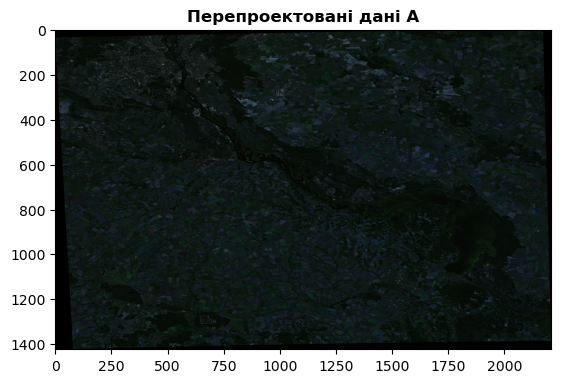

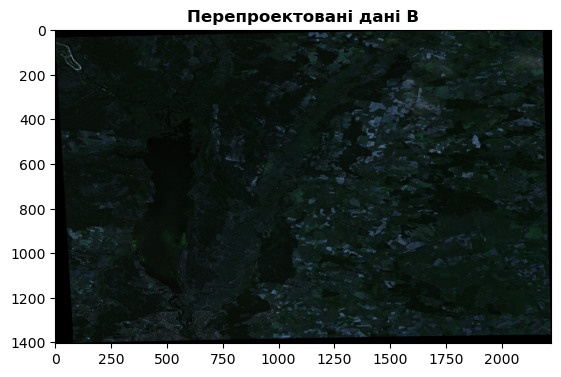

In [122]:
for dataset in ['A', 'B']:
    input_path = f'lab7_data/sentinel_concat/{dataset}/concat_{dataset}.tif'
    output_path = f'lab7_data/sentinel_concat/{dataset}/projected_{dataset}_4326.tif'
    gdalwarp_cmd = f'gdalwarp -t_srs EPSG:4326 {input_path} {output_path}'
    result = subprocess.run(gdalwarp_cmd, shell=True)

projected_datasets = {}
for dataset in ['A', 'B']:
    output_path = f'lab7_data/sentinel_concat/{dataset}/projected_{dataset}_4326.tif'
    projected_datasets[dataset] = rasterio.open(output_path)

for dataset, raster in projected_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Перепроектовані дані {dataset}')


#### 4. Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


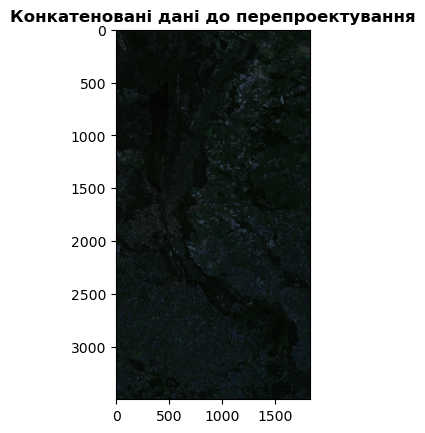

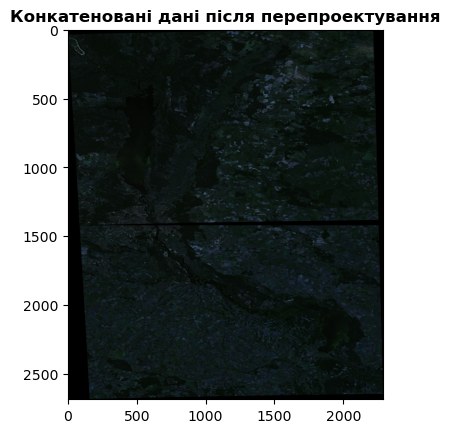

In [123]:
merge_cmd1 = 'gdal_merge.py -o lab7_data/sentinel_concat/general.tif lab7_data/sentinel_concat/A/concat_A.tif lab7_data/sentinel_concat/B/concat_B.tif'
result1 = subprocess.run(merge_cmd1, shell=True)

merge_cmd2 = 'gdal_merge.py -o lab7_data/sentinel_concat/general4326.tif lab7_data/sentinel_concat/A/projected_A_4326.tif lab7_data/sentinel_concat/B/projected_B_4326.tif'
result2 = subprocess.run(merge_cmd2, shell=True)

all = {'до перепроектування': rasterio.open('lab7_data/sentinel_concat/general.tif'),
        'після перепроектування': rasterio.open('lab7_data/sentinel_concat/general4326.tif')}

for type, raster in all.items():
        show(raster.read([1, 2, 3]), adjust=True, title=f'Конкатеновані дані {type}')

#### 5. Обрізання результуючого зображення по заданому векторному контуру.

Creating output file that is 677P x 707L.
Processing lab7_data/sentinel_concat/general.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 805P x 527L.
Processing lab7_data/sentinel_concat/general4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


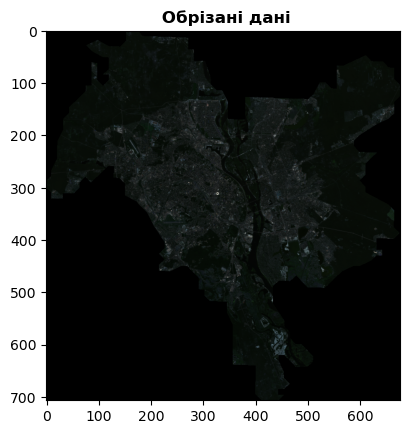

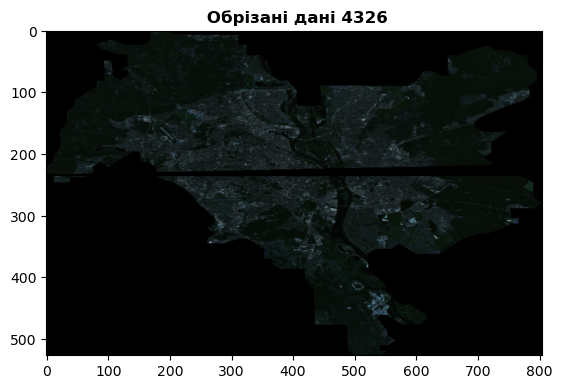

In [124]:
gdalwarp_cmd1 = 'gdalwarp -cutline lab7_data/Kyiv_regions.shp -crop_to_cutline lab7_data/sentinel_concat/general.tif lab7_data/sentinel_concat/cut.tif'
result_1 = subprocess.run(gdalwarp_cmd1, shell=True)

gdalwarp_cmd2 = 'gdalwarp -cutline lab7_data/Kyiv_regions.shp -crop_to_cutline lab7_data/sentinel_concat/general4326.tif lab7_data/sentinel_concat/cut4326.tif'
result_2 = subprocess.run(gdalwarp_cmd2, shell=True)

cut_data = {'Обрізані дані': rasterio.open('lab7_data/sentinel_concat/cut.tif'),
        'Обрізані дані 4326': rasterio.open('lab7_data/sentinel_concat/cut4326.tif')}

for type, raster in cut_data.items():
        show(raster.read([1, 2, 3]), adjust=True, title=f' {type}')


---

#### Спочатку завантажуємо дані Landset для міста Одеси (два сусідніх знимки) та об'єднуємо усі канали.

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


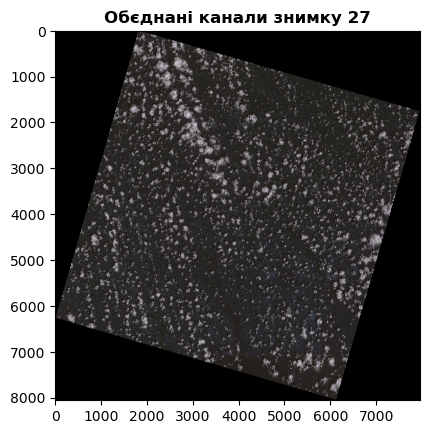

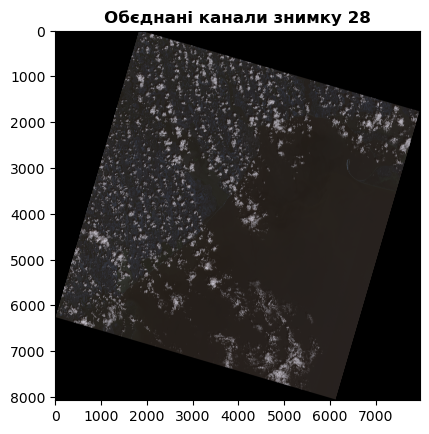

In [139]:
path2 = "lab7_data/Landset"

datasets2 = {'27': "180027", '28': "180028"}
bands2 = ['B2', 'B3', 'B4', 'B8']

data_paths = {}
for dataset, folder in datasets2.items():
    data_paths[dataset] = {band: f"{path2}/{folder}/LC08_L1TP_{folder}_20230710_20230718_02_T1_{band}.TIF" for band in bands2}

output_dirs = [f"{path2}/27", f"{path2}/28"]
for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

for dataset, paths in data_paths.items():
    output_file = f'{path2}/{dataset}/concat_{dataset}.tif'   
    merge_cmd = f'gdal_merge.py -o {output_file} -separate {" ".join(paths.values())}'
    result = subprocess.run(merge_cmd, shell=True)

merged_datasets2 = {}
for dataset in datasets2.keys():
    output_file = f'{path2}/{dataset}/concat_{dataset}.tif'
    merged_datasets2[dataset] = rasterio.open(output_file)

for dataset, raster in merged_datasets2.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Обєднані канали знимку {dataset}')


#### Конкатенуємо в одне зображення:

0...10...20...30...40...50...60...70...80...90...100 - done.


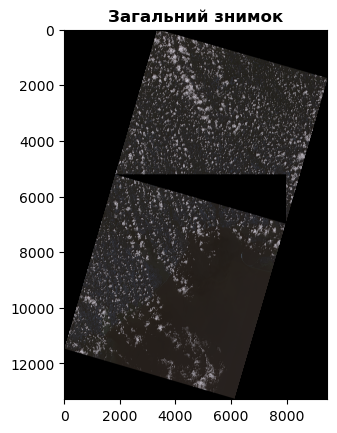

<Axes: title={'center': 'Загальний знимок'}>

In [140]:
final_output_file = f'{path2}/final.tif'
concat_cmd = f'gdal_merge.py -o {final_output_file} {" ".join([f"{path2}/27/concat_27.tif", f"{path2}/28/concat_28.tif"])}'
result = subprocess.run(concat_cmd, shell=True)

final_raster = rasterio.open(final_output_file)
show(final_raster.read([1, 2, 3]), adjust=True, title='Загальний знимок')


#### Тепер об'єднаємо лише RGB канали для кожного знимку:

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


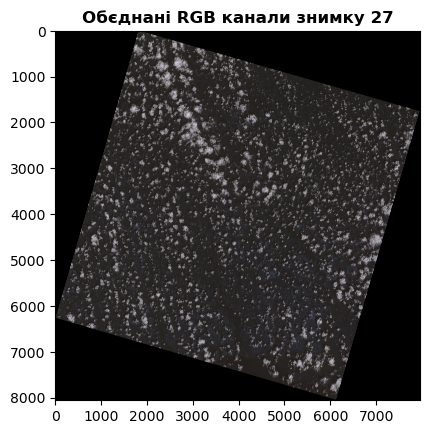

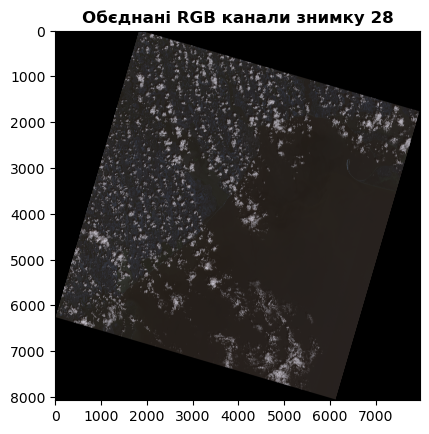

In [141]:
datasets = {'27': "180027", '28': "180028"}
bands_rgb = ['B2', 'B3', 'B4']

paths_rgb = {}
for dataset, folder in datasets.items():
    paths_rgb[dataset] = {band: f"{path2}/{folder}/LC08_L1TP_{folder}_20230710_20230718_02_T1_{band}.TIF" for band in bands_rgb}

for dataset, paths in paths_rgb.items():
    output_file = f'{path2}/{dataset}/rgb_{dataset}.tif'
    rgb_cmd = f'gdal_merge.py -o {output_file} -separate {" ".join(paths.values())}'
    result = subprocess.run(rgb_cmd, shell=True)
    
rgb_datasets = {}
for dataset in datasets.keys():
    output_file = f'{path2}/{dataset}/rgb_{dataset}.tif'
    rgb_datasets[dataset] = rasterio.open(output_file)

for dataset, raster in rgb_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Обєднані RGB канали знимку {dataset}')


#### Переведіть панхроматичний канал у 30 м, а RGB канали у 60 метрів.

Input file size is 15901, 16121
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 15921, 16141
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 7951, 8061
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 7961, 8071
0...10...20...30...40...50...60...70...80...90...100 - done.


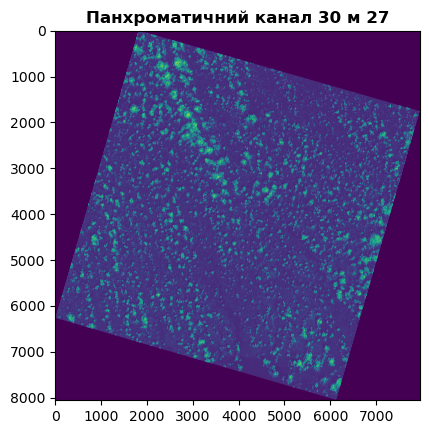

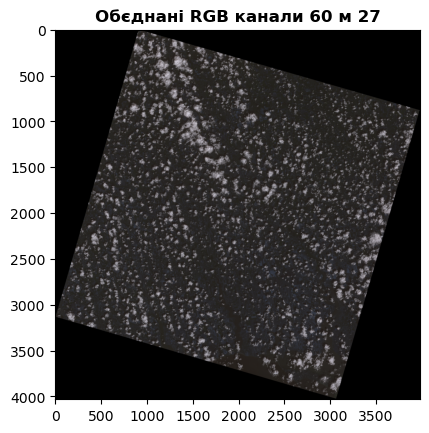

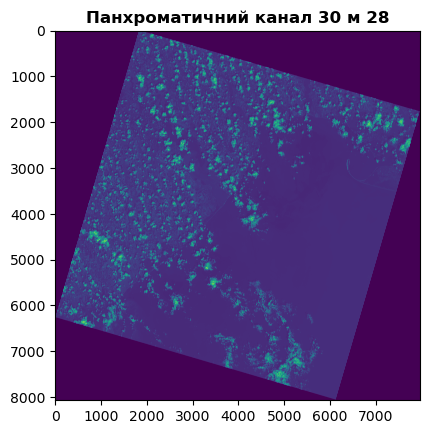

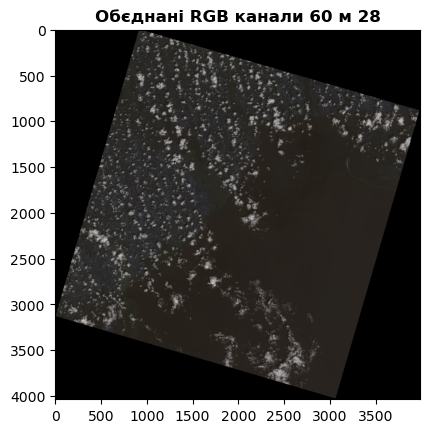

In [142]:
pan_band = 'B8'

for dataset, folder in datasets.items():
    pan_file = f"{path2}/{folder}/LC08_L1TP_{folder}_20230710_20230718_02_T1_{pan_band}.TIF"
    pan_out_file = f'{path2}/{dataset}/pan_{dataset}_30m.tif'
    
    cmd30 = f'gdal_translate -tr 30 30  {pan_file} {pan_out_file}'
    result = subprocess.run(cmd30, shell=True)

for dataset in datasets.keys():
    rgb_file = f'{path2}/{dataset}/rgb_{dataset}.tif'
    rgb_output_file = f'{path2}/{dataset}/rgb_{dataset}_60m.tif'
    
    cmd60 = f'gdal_translate -tr 60 60  {rgb_file} {rgb_output_file}'
    result = subprocess.run(cmd60, shell=True)
    
for dataset in datasets.keys():
    pan_output_file = f'{path2}/{dataset}/pan_{dataset}_30m.tif'
    rgb_output_file = f'{path2}/{dataset}/rgb_{dataset}_60m.tif'
    
    pan_rast = rasterio.open(pan_output_file)
    show(pan_rast.read(1), adjust=True, title=f'Панхроматичний канал 30 м {dataset}')

    rgb_rast = rasterio.open(rgb_output_file)
    show(rgb_rast.read([1, 2, 3]), adjust=True, title=f'Обєднані RGB канали 60 м {dataset}')

#### Після цього паншарпніть 60 метровий RGB за допомогою 30 м панхроматичного каналу.

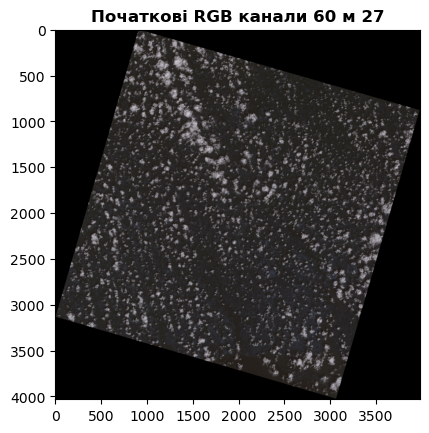

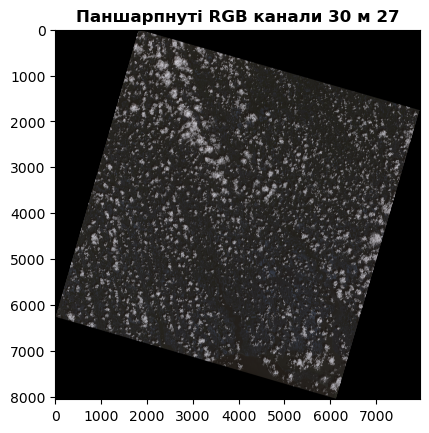

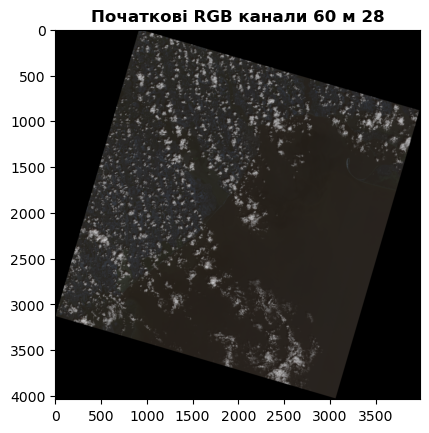

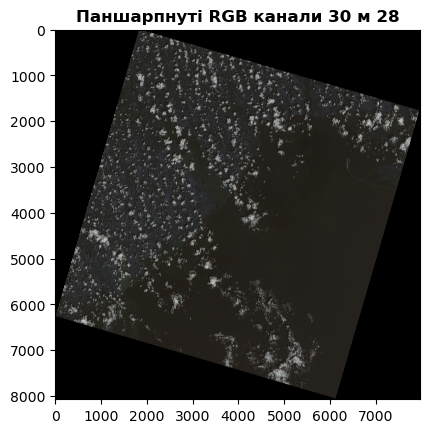

In [148]:
datasets = {'27': "180027", '28': "180028"}
path2 = 'lab7_data/Landset'

for dataset in datasets.keys():
    pan_file = f'{path2}/{dataset}/pan_{dataset}_30m.tif'
    rgb_file = f'{path2}/{dataset}/rgb_{dataset}_60m.tif'
    pansh_output_file = f'{path2}/{dataset}/pansharpen_{dataset}_30m.tif'

    pansharpen_cmd = f'gdal_pansharpen.py -of GTiff -r nearest {pan_file} {rgb_file} {pansh_output_file}'
    result = subprocess.run(pansharpen_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    

for dataset in datasets.keys():
    original_rgb_file = f'{path2}/{dataset}/rgb_{dataset}_60m.tif'
    pansh_output_file = f'{path2}/{dataset}/pansharpen_{dataset}_30m.tif'

    with rasterio.open(original_rgb_file) as rgb_file_raster:
        show(rgb_file_raster.read([1, 2, 3]), adjust=True, title=f'Початкові RGB канали 60 м {dataset}')

    with rasterio.open(pansh_output_file) as pansh_rgb_raster:
        show(pansh_rgb_raster.read([1, 2, 3]), adjust=True, title=f'Паншарпнуті RGB канали 30 м {dataset}')




#### Підрахуйте метрики точності паншарпенінгу. За даними метриками виберіть найкращий метод паншарпенінгу.

In [149]:
methods = ['average', 'nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos']

def resize(input_file, output_file, width, height):
    resize_cmd = f'gdal_translate -of GTiff -outsize {width} {height} {input_file} {output_file}'
    subprocess.run(resize_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def pansharpening(method, dataset):
    pan_file = f'{path2}/{dataset}/pan_{dataset}_30m.tif'
    rgb_file = f'{path2}/{dataset}/rgb_{dataset}_60m.tif'
    output_file = f'{path2}/{dataset}/pansharpen_{method}_{dataset}_30m.tif'    
    gdal_pansharpen = f'gdal_pansharpen.py -of GTiff -r {method} {pan_file} {rgb_file} {output_file}'
    result = subprocess.run(gdal_pansharpen, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def read(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()
        return data.flatten(), src.shape

def calculate(original, pansharpened):
    mse = mean_squared_error(original, pansharpened)
    r2 = r2_score(original, pansharpened)
    return mse, r2

metrics = {}

for method in methods:
    mse_values = []
    r2_values = []
    for dataset in datasets:
        pan_file = f'{path2}/{dataset}/pan_{dataset}_30m.tif'
        rgb_file = f'{path2}/{dataset}/rgb_{dataset}_60m.tif'
        
        with rasterio.open(pan_file) as pan_src:
            width, height = pan_src.width, pan_src.height
        
        resized_rgb_file = f'{path2}/{dataset}/resized_rgb_{dataset}_30m.tif'
        resize(rgb_file, resized_rgb_file, width, height)
        
        pansharpening(method, dataset)
        
        original_rgb_file = resized_rgb_file
        pansharpened_file = f'{path2}/{dataset}/pansharpen_{method}_{dataset}_30m.tif'
        
        original_rgb, original_shape = read(original_rgb_file)
        pansharpened_rgb, pansharpened_shape = read(pansharpened_file)
        
        mse, r2 = calculate(original_rgb, pansharpened_rgb)
        mse_values.append(mse)
        r2_values.append(r2)

    metrics[method] = { 'MSE': np.mean(mse_values),
                        'R^2': np.mean(r2_values) }

print("Метрики точності для паншарпнутих зображень:")
for method, metric in metrics.items():
    print(f"\nМетод: {method}")
    print(f"  Середнє MSE: {metric['MSE']}")
    print(f"  Середнє R^2: {metric['R^2']}")

min_mse = min(metric['MSE'] for metric in metrics.values())
for method in metrics:
    if metrics[method]['MSE'] == min_mse:
        best_method = method
        break

print(f"\nНайкращий метод паншарпенінгу: {best_method} з середнім MSE: {min_mse}")

Метрики точності для паншарпнутих зображень:

Метод: average
  Середнє MSE: 19580.150588624143
  Середнє R^2: 0.9997019781064727

Метод: nearest
  Середнє MSE: 19569.41378223837
  Середнє R^2: 0.9997021500939849

Метод: bilinear
  Середнє MSE: 19557.028222498175
  Середнє R^2: 0.9997022980697063

Метод: cubic
  Середнє MSE: 19569.40122387487
  Середнє R^2: 0.9997021298577361

Метод: cubicspline
  Середнє MSE: 19519.166696718312
  Середнє R^2: 0.9997027620230512

Метод: lanczos
  Середнє MSE: 19563.20428284489
  Середнє R^2: 0.9997022167914836

Найкращий метод паншарпенінгу: cubicspline з середнім MSE: 19519.166696718312
